In [1]:
import os
import random
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import Dataset
import cv2

import numpy as np
import pandas as pd

from pycocotools.coco import COCO

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False

# GPU 사용 가능 여부에 따라 device 정보 저장
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
device

'cuda'

In [3]:
%matplotlib inline

dataset_path  = '/opt/ml/input/data'
anns_file_path = dataset_path + '/' + 'train_all.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

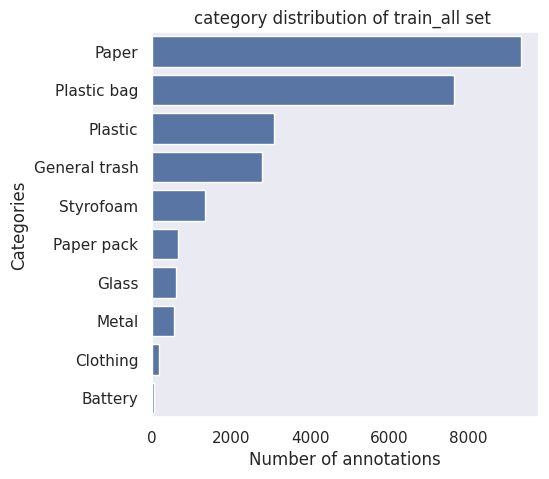

In [7]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")

In [8]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

## 데이터 전처리 함수 정의 (Dataset)

In [9]:
category_names = list(sorted_df.Categories)

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        self.ids = list(sorted(self.coco.imgs.keys()))
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=self.ids[index])
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # General trash = 1, ... , Cigarette = 10
            anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                pixel_value = category_names.index(className)
                masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            masks = masks.astype(np.int8)
                        
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
            return images, masks, image_infos
        
        if self.mode == 'test':
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
            return images, image_infos
    
    def __len__(self) -> int:
        return len(self.coco.getImgIds())

## Dataset 정의 및 DataLoader 할당

In [10]:
# train.json / validation.json 디렉토리 설정
train_path = dataset_path + '/stratified_group_kfold/train_fold0.json'
val_path = dataset_path + '/stratified_group_kfold/val_fold0.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

batch_size = 1  

train_transform = A.Compose([
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          ToTensorV2()
                          ])

# train dataset
train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)

# validation dataset
val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)

# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=4,
                                           collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4,
                                         collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.66s)
creating index...
index created!


## Mask image 생성

In [15]:
!mkdir -p /opt/ml/input/data/mmseg/annotations/training
!mkdir -p /opt/ml/input/data/mmseg/annotations/validation

In [16]:
for imgs, masks, image_infos in train_loader:
    image_infos = image_infos[0]
    file_dir = f"/opt/ml/input/data/mmseg/annotations/training/{image_infos['id']:04}.png"

    masks = masks[0].numpy()
    print(f"writing to {file_dir}")
    cv2.imwrite(file_dir, masks)

for imgs, masks, image_infos in val_loader:
    image_infos = image_infos[0]
    file_dir = f"/opt/ml/input/data/mmseg/annotations/validation/{image_infos['id']:04}.png"

    masks = masks[0].numpy()
    print(f"writing to {file_dir}")
    cv2.imwrite(file_dir, masks)

writing to /opt/ml/input/data/mmseg/annotations/training/0000.png
writing to /opt/ml/input/data/mmseg/annotations/training/0001.png
writing to /opt/ml/input/data/mmseg/annotations/training/0002.png
writing to /opt/ml/input/data/mmseg/annotations/training/0003.png
writing to /opt/ml/input/data/mmseg/annotations/training/0004.png
writing to /opt/ml/input/data/mmseg/annotations/training/0005.png
writing to /opt/ml/input/data/mmseg/annotations/training/0006.png
writing to /opt/ml/input/data/mmseg/annotations/training/0007.png
writing to /opt/ml/input/data/mmseg/annotations/training/0008.png
writing to /opt/ml/input/data/mmseg/annotations/training/0009.png
writing to /opt/ml/input/data/mmseg/annotations/training/0010.png
writing to /opt/ml/input/data/mmseg/annotations/training/0011.png
writing to /opt/ml/input/data/mmseg/annotations/training/0012.png
writing to /opt/ml/input/data/mmseg/annotations/training/0013.png
writing to /opt/ml/input/data/mmseg/annotations/training/0014.png
writing to